This week I am going to look at line plots with Xarray. Xarray plotting is based on Matplotlib. But Xarray gives polished plots quicker as it automatically uses the metadata in the netcdf file for labelling the plot. Also, a lot of plotting tasks can be achieved in a line. Of course, if your netcdf file is lacking information, you'll still need to add to the plot using Matplotlib. I'll summarise here how to plot:
- timeseries
- multi-line plots
- vertical profiles
- panel plots
Some previous knowledge of Xarray is assumed. If you haven't used Xarray before you might need to refer to the [Xarray documentation](http://xarray.pydata.org/en/stable/index.html) or some previous blog posts.

First, let's get ourselves some 4D data: time, height, latitude and longitude. CMIP5 is a good source of those, let's pick some atmospheric temperature.

In [6]:
%matplotlib inline
import xarray

datapath = '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/ta/'
ds = xarray.open_dataset(datapath + 'ta_day_ACCESS1-3_historical_r1i1p1_19500101-19541231.nc')
ta = ds['ta']
ta

<xarray.DataArray 'ta' (time: 1826, plev: 8, lat: 144, lon: 192)>
[403881984 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 1950-01-02T12:00:00 ...
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 -84.38 -83.12 -81.88 ...
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 8.438 10.31 12.19 14.06 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-06-12T22:50:20Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

# Line plot types

## Timeseries
To plot a timeseries (or a simple one line plot) is quite easy with Xarray, you simply need a 1D variable. Since ours is 4D, let's choose to plot the temperature timeseries at 850hPa (plev=85,000) and over Canberra (35.28S, 149.13E)

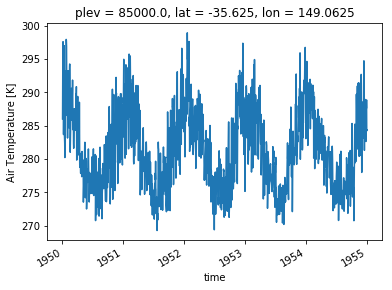

In [7]:
ta_CBR = ta.sel(lat=-35.28, lon=149.13, method='nearest')
ta_CBR.sel(plev=85000).plot()

You can see the plot has already quite a lot of useful labels. Axes are labelled (with unit for the quantity plotted) and the spatial position of the point is at the top. You may want to customise the plot. The `plot()` method in Xarray is calling the appropriate plot method of Matplotlib. This means you can customise your plots in the same way in Xarray as you would in Matplotlib. In particular, the line plots accept a range of properties that allow you to customise the line appearance. Here is a [list of all possible properties](https://matplotlib.org/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D) for a line plot. It might also be easier to simply search the internet for an example of what you want to do.

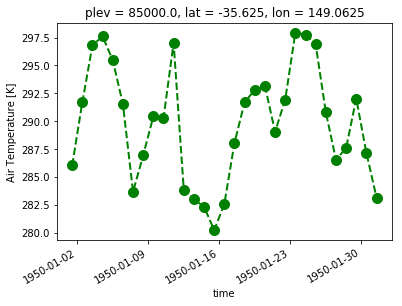

In [8]:
# An example of customisation

ta_CBR.sel(time=slice('1950-01-01','1950-01-31'), plev=85000).plot(linestyle='dashed',color='g', linewidth=2, marker='o',markersize=10)='dashed',color='g', linewidth=2, marker='o',markersize=10)

## Multiple lines
Now, let's say you want to plot the temperature timeseries at different pressure levels. Then, you need 2D data with dimensions time and pressure. Then Xarray let's you determine which dimension should be used for different lines with the argument `hue`.

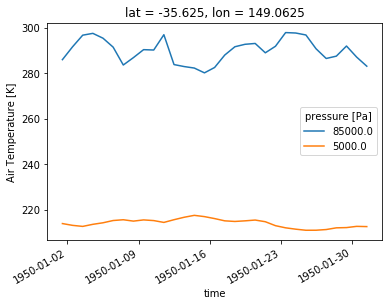

In [9]:
ta_CBR.sel(time=slice('1950-01-01','1950-01-31'),plev=[85000,5000]).plot(hue='plev')

We again get reasonable labelling by default.

## Vertical profile
A vertical profile is the same as a timeseries: get a 1D array along the vertical dimension. However, the data needs to be plotted along the x-axis and the vertical dimension along the y-axis. Xarray allows you to set this through the `y` argument of the `plot()` function. 

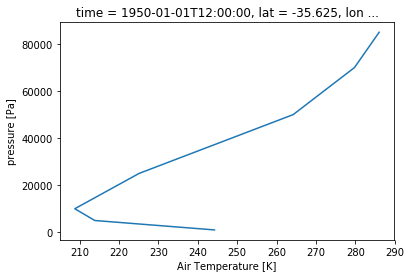

In [10]:
ta_CBR.sel(time='1950-01-01').plot(y='plev')

Although as you see here, there is another issue to tackle. By default, Xarray will plot the dimension with increasing values. Obviously if you have a pressure dimension or a depth dimension, that is not what you want. To fix this, use the `yincrease` argument.

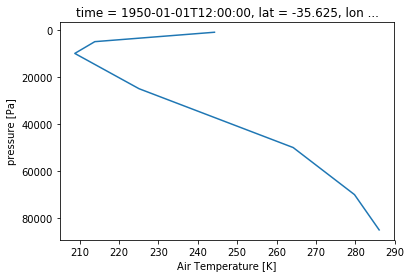

In [11]:
ta_CBR.sel(time='1950-01-01').plot(y='plev', yincrease=False)

## Panel plot
Let's say, instead of a multi-line plot, you want a panel plot of vertical profiles over Canberra for the first 10 days of 1950. Xarray let's you do that without defining the panel plot first! You need to use the `row` or `col` and `col_wrap` arguments. `row` or `col` tell Xarray what dimension to use along the rows or columns. `col_wrap` tells Xarray how many columns to use. Note that panel plots are also called faceted plots such as in the Xarray documentation.

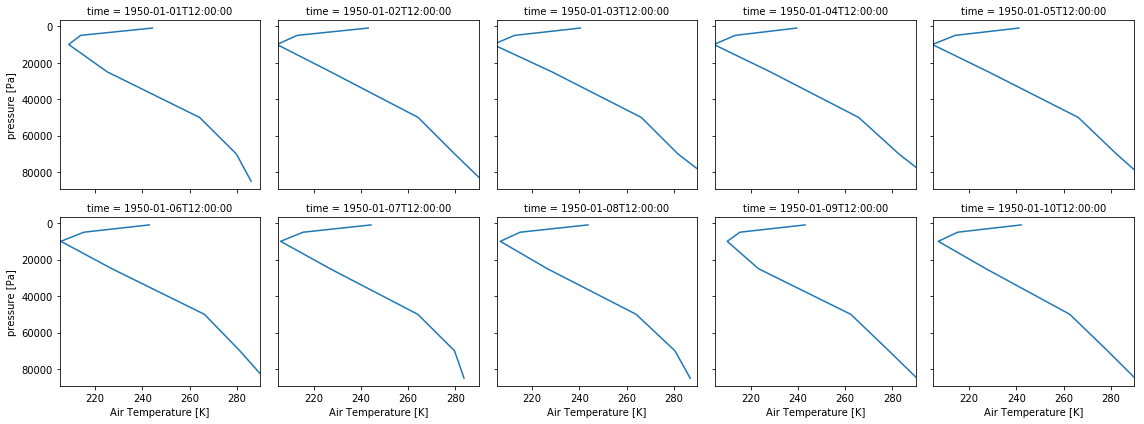

In [12]:
ta_CBR.sel(time=slice('1950-01-01','1950-01-10')).plot(y='plev', yincrease=False, col='time', col_wrap=5)

# A more advance example
Now that we've seen the basics, let's bring it all together on a more realistic example. Let's say you want to compare Canberra and Sydney air temperature profiles in 1950. You want to compare the profiles on 1st January, 31st December and show some yearly statistics (mean, standard deviation...).

First we need to calculate all the quantities we need and store them in a single DataArray. For this, you'll want to store the quantities and add 2 coordinates: one for the city and one for the statistic. This way, you can tell Xarray to use those coordinates for your plot

In [13]:
ta_CBR_1950 = ta_CBR.sel(time='1950')
ta_CBR_1950.coords['city'] = 'Canberra'
# We want the 1st January and 31st December. But we don't want to keep the time dimension and coordinate as the mean
# does not have those. We need to keep track of the date in a new coordinate we'll call 'stats'
ta_CBR_195001 = ta_CBR_1950.sel(time='1950-01-01').squeeze('time').drop('time')
ta_CBR_195001.coords['stats'] = '1st January' 
ta_CBR_195012 = ta_CBR_1950.sel(time='1950-12-31').squeeze('time').drop('time')
ta_CBR_195012.coords['stats'] = '31st December'
ta_CBR_1950_mean = ta_CBR_1950.mean(dim='time')
ta_CBR_1950_mean.coords['stats'] = 'mean'

Now we use the `concat()` function from xarray to concatenate all the statistics in a single DataArray. This array will simply contain 3 vertical profiles. It is also possible to create the DataArray first and to fill it with the statistics. Choose whichever approach makes sense depending on your problem.

In [14]:
ta_CBR_1950_stats = xarray.concat([ta_CBR_195001, ta_CBR_195012, ta_CBR_1950_mean],'stats')
ta_CBR_1950_stats

<xarray.DataArray 'ta' (stats: 3, plev: 8)>
array([[      nan, 286.02872, 279.76532, 264.2014 , 225.07121, 208.75842,
        213.83624, 244.21983],
       [      nan, 289.20227, 276.6931 , 259.72153, 224.56906, 209.45264,
        216.86447, 243.77567],
       [      nan, 281.65936, 273.80573, 257.87796, 223.91864, 210.82764,
        214.47987, 234.8242 ]], dtype=float32)
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
    lat      float64 -35.62
    lon      float64 149.1
    city     <U8 'Canberra'
  * stats    (stats) <U13 '1st January' '31st December' 'mean'

In [15]:
ta_SYD = ta.sel(lat=-33.87, lon=151.21, method='nearest').sel(time='1950')
ta_SYD.coords['city']='Sydney'
ta_SYD_195001 = ta_SYD.sel(time='1950-01-01').squeeze('time').drop('time')
ta_SYD_195001.coords['stats'] = '1st January' 
ta_SYD_195012 = ta_SYD.sel(time='1950-12-31').squeeze('time').drop('time')
ta_SYD_195012.coords['stats'] = '31st December'
ta_SYD_1950_mean = ta_SYD.mean(dim='time')
ta_SYD_1950_mean.coords['stats'] = 'mean'
ta_SYD_1950_stats = xarray.concat([ta_SYD_195001, ta_SYD_195012, ta_SYD_1950_mean],'stats')
ta_SYD_1950_stats

<xarray.DataArray 'ta' (stats: 3, plev: 8)>
array([[      nan, 285.57645, 281.2667 , 264.9933 , 225.27211, 208.35411,
        213.23886, 243.64713],
       [      nan, 291.8125 , 277.7788 , 260.8064 , 224.94211, 208.00836,
        215.49797, 243.43637],
       [      nan, 282.4153 , 274.38565, 258.48856, 224.57526, 209.86441,
        213.90916, 235.06212]], dtype=float32)
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
    lat      float64 -34.38
    lon      float64 150.9
    city     <U6 'Sydney'
  * stats    (stats) <U13 '1st January' '31st December' 'mean'

Now we still have to concatenate Sydney and Canberra together so we have our 6 profiles in the same array.

In [16]:
ta_1950_stats = xarray.concat([ta_CBR_1950_stats, ta_SYD_1950_stats],'city')
ta_1950_stats

<xarray.DataArray 'ta' (city: 2, stats: 3, plev: 8)>
array([[[      nan, 286.02872, 279.76532, 264.2014 , 225.07121, 208.75842,
         213.83624, 244.21983],
        [      nan, 289.20227, 276.6931 , 259.72153, 224.56906, 209.45264,
         216.86447, 243.77567],
        [      nan, 281.65936, 273.80573, 257.87796, 223.91864, 210.82764,
         214.47987, 234.8242 ]],

       [[      nan, 285.57645, 281.2667 , 264.9933 , 225.27211, 208.35411,
         213.23886, 243.64713],
        [      nan, 291.8125 , 277.7788 , 260.8064 , 224.94211, 208.00836,
         215.49797, 243.43637],
        [      nan, 282.4153 , 274.38565, 258.48856, 224.57526, 209.86441,
         213.90916, 235.06212]]], dtype=float32)
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * stats    (stats) <U13 '1st January' '31st December' 'mean'
    lat      (city) float64 -35.62 -34.38
    lon      (city) float64 149.1 150.9
  * city     (city) <U8 'Canberra' 'Sydney'

Now, we just need one line to plot everything!

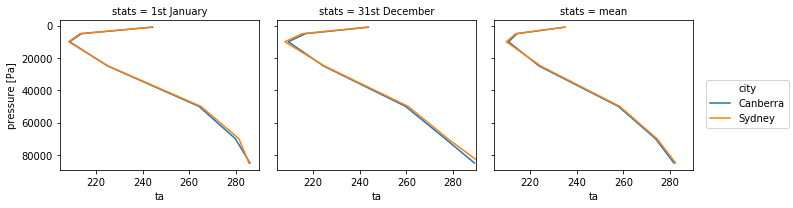

In [17]:
ta_1950_stats.plot(hue='city',col='stats',y='plev',yincrease=False)

Note that with the averaging, the variable lost its attributes, you may need to add the long name and unit again for better labelling.

## Different range in x or y
The above example only works if all the plots have the same range. If you tried to plot the standard deviation in the panel above following this method, the plot would appear empty as the values of the standard deviation are much smaller than the temperature. Xarray provides the `sharex` argument that allows for different x axes. Obviously all plots will then use slighly different x axes then which may or may not be acceptable. Xarray also provides a `sharey` argument when the y axis needs to change and which is used in the same way.

In [19]:
# Get the standard deviations for Sydney and Canberra and add to the stats.
ta_SYD_1950_std = ta_SYD.std(dim='time')
ta_SYD_1950_std.coords['stats'] = 'std'
ta_CBR_1950_std = ta_CBR_1950.std(dim='time')
ta_CBR_1950_std.coords['stats'] = 'std'
ta_1950_std = xarray.concat([ta_SYD_1950_std, ta_CBR_1950_std],'city')
ta_1950_add_stats= xarray.concat([ta_1950_stats, ta_1950_std], 'stats')

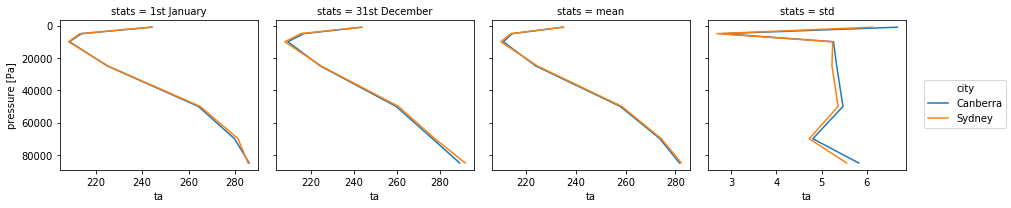

In [20]:
# Plot in panel but with a different x axis range for all plots.
ta_1950_add_stats.plot(hue='city',col='stats',col_wrap=4,y='plev',yincrease=False,sharex=False)